In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import math
import axionDM3
import pyfftw
import os
import sys
import multiprocessing
import numpy
import numba
import h5py
from IPython.core.display import clear_output
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Set Axion Mass

In [2]:
axion_mass = 1e-22 *1.783e-36 #kg

# Set units for soliton parameters
s_mass_unit = ''     #Accepted units: 'kg', 'solar_masses', 'M_solar_masses', and '' for dimensionless units as used in [1]
s_position_unit = '' #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units as used in [1]
s_velocity_unit = '' #Accepted units: 'm/s', 'km/s', 'km/h', and '' for dimensionless units as used in [1]

# Set Simulation Parameters

In [7]:
# Set number of threads to target
num_threads = multiprocessing.cpu_count()
print(num_threads)

# Set box size and resolution
length = 6 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5
length_units = ''  #Accepted units: 'm', 'km', 'pc', 'kpc', 'Mpc', 'ly', and '' for dimensionless units as used in [1]

resol=128 #Note that for resol 128, the largest stable soliton mass is ~ 50 in code units 

# Set duration of simulation in given units
duration = 4.5 #1 code unit is ~70 Gyr (no rescaling with m_a)

duration_units = ''  #Accepted units: 's', 'yr', 'kyr', 'Myr', and '' for dimensionless units as used in [1]

start_time = 0.0 #Should be given in the same units as duration. 

#central_mass = 2000.0 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
central_mass = 0. #Give this parameter in the SAME units as the soliton mass unit. i.e. units must match with s_mass_unit

# Set options for what to save, where to save, and in what format to save it

#Data to save
save_rho = False
save_psi = False
save_plane = True
save_energies = True
save_stability = False
save_line = True

#Formats to save to
hdf5 = False
npz = False
npy = True

step_factor = 1. # Change this to a larger number if velocities are sufficiently low that constraint on timestep can be relaxed. 
save_number = 400     # Choose number of 'frames' to save. Note that, depending on resolution, this could require significant disk space.
save_path = 'TestOutput'  # Set output directory

save_options = [save_rho,save_psi,save_plane,save_energies,save_stability,save_line]

4


# Set Initial Conditions:

In [8]:
m = 22 #1 code unit is ~2.3e6 M_sol (1e-22/m_a)^1.5
r = 1 #1 code unit is ~38 kpc x (1e-22/m_a)^0.5
#v = np.sqrt(central_mass/r)
#Soliton parameters are mass, position, velocity and phase (radians)
soliton4 = [m, [r,0,0], [0,1.8,0], 0]
soliton5 = [m, [-r,0,0], [0,-1.8,0], 0]
solitons = [soliton4, soliton5]  

#Note that the output files are always named according to the mass and radius of the first soliton in this list

# Run:

In [9]:
#evolve_jit=numba.jit(axionDM3.evolve)
#evolve_jit(central_mass, num_threads, length, length_units, resol, duration, duration_units, save_number, save_options, save_path, npz, npy, txt, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons)
axionDM3.evolve(central_mass, num_threads, length, length_units, resol, duration, duration_units, step_factor, save_number, save_options, save_path, npz, npy, hdf5, s_mass_unit, s_position_unit, s_velocity_unit, solitons, start_time)



Complete.


# Visualisations:

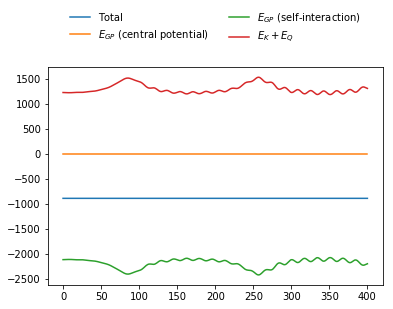

In [10]:
output_animated = 2
# 0 for all contours plotted on a single graph, 1 for an animation in time, 2 for energy lists 
#over time, 3 for line along axis of symmetry, 4 for Egp plane over time 
save_plots = 0 
# 0 to display contours without saving, 1 to save as well. 


with open('{}{}'.format(save_path, '/timestamp.txt'), 'r') as timestamp:
  ts = timestamp.read()

loc = save_path + '/' + ts

if output_animated == 2:

    egylist = np.load('{}{}'.format(loc, '/egylist.npy')).tolist()
    egpcmlist = np.load('{}{}'.format(loc, '/egpcmlist.npy')).tolist()
    egpsilist = np.load('{}{}'.format(loc, '/egpsilist.npy')).tolist()
    ekandqlist = np.load('{}{}'.format(loc, '/ekandqlist.npy')).tolist()
    masslist = np.load('{}{}'.format(loc, '/masslist.npy')).tolist()
    plt.plot(egylist,label='Total')
    plt.plot(egpcmlist,label='$E_{GP}$ (central potential)')
    plt.plot(egpsilist,label='$E_{GP}$ (self-interaction)')
    plt.plot(ekandqlist,label='$E_{K}+E_{Q}$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), frameon=False, ncol=2)
    if save_plots == 1:
        plt.savefig('./Visualisations/energy_diagram.eps', format='eps', dpi=1000)
    plt.show()

if output_animated == 0:
    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    for x in np.arange(0,save_number+1,1):
        if x == 0:
            plt.contour(np.load('{}{}{}{}'.format(loc, '/plane_#',x,'.npy')),colors='k')
        if x in np.arange(1,save_number+1,1):
            plt.contour(np.load('{}{}{}{}'.format(loc, '/plane_#',x,'.npy')))
            plt.axes().set_aspect('equal')
    if save_plots == 1:
        plt.savefig('{}'.format('./Visualisations/Static_contours.eps'), format='eps', dpi=1000)


if output_animated in (1,3,4):        

    import warnings 
    warnings.filterwarnings("ignore")
    plt.ioff()
    fig,ax = plt.subplots(figsize=(20, 10))
    plt.axes().set_aspect('equal')
    
    data = []
    
    for x in np.arange(0,save_number+1,1):
        if output_animated == 1:
            data.append(np.load('{}{}{}{}'.format(loc, '/plane_#', x, '.npy')))
        if output_animated == 3:
            data.append(np.load('{}{}{}{}'.format(loc, '/line_#', x, '.npy')))
        if output_animated == 4:
            data.append(np.load('{}{}{}{}'.format(loc, '/egp_plane_#', x ,'.npy')))

    def animate(i):
        plt.clf()
        if output_animated in (1, 4):
            plot = plt.contour(data[i])
            plt.axes().set_aspect('equal')
            plt.axes().get_xaxis().set_ticks([])
            plt.axes().get_yaxis().set_ticks([])
        if output_animated == 1:
            plt.title('Mass Density - Plane')
        if output_animated == 4:
            plt.title('Gravitational Potential Energy Density')
        if output_animated == 3:
            plt.clf()
            plot = plt.plot(data[i])    
            plt.title('Mass Density - Line')
            plt.axes().set_ylim(0,max(data[0]))
            
            
    interval = 0.15 #in seconds
    ani = matplotlib.animation.FuncAnimation(fig,animate,save_number+1,interval=interval*1e+3,blit=False)
    
    from IPython.display import HTML
    animated_plot = HTML(ani.to_jshtml())

    if save_plots == 1:  
        save_html = animated_plot.data
        if output_animated == 1:
            with open('./Visualisations/plane_animation.html', 'w') as f:
                f.write(save_html)
        if output_animated == 3:
            with open('./Visualisations/line_animation.html', 'w') as f:
                f.write(save_html)
        if output_animated == 4:
            with open('./Visualisations/Egp_animation.html', 'w') as f:
                f.write(save_html)

    display(animated_plot) 
    plt.close()    




  